In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
sys.path.append("..")

from src.utils.file import get_paths_recursive
from src.config import SKY_FINDER_COVER_PATH

In [3]:
def calculate_weights(ground_truth_folder, name):
    """
    Calculate BCE weights for continuous ground truth masks.
    For continuous values, we can compute the average value across all pixels.
    """
    print(f"Calculating BCE weights for {name} ground truths...")
    
    # Get all ground truth files
    gt_files = get_paths_recursive(
        folder_path=ground_truth_folder,
        match_pattern="*.jpg",
        path_type="f",
        recursive=True,
    )
    
    if len(gt_files) == 0:
        print(f"No files found in {ground_truth_folder}")
        return None
    
    print(f"Found {len(gt_files)} {name} ground truth files")
    
    # Calculate total pixel count and positive pixel values (even for continuous masks)
    total_pixels = 0
    positive_pixel_sum = 0
    
    # For histogram
    histogram_values = []
    
    for gt_file in tqdm(gt_files):
        # Load the ground truth image
        img = cv2.imread(gt_file, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load {gt_file}, skipping")
            continue
        
        # Normalize to 0-1 range
        img = img / 255.0
        
        # Update counters
        pixel_count = img.size
        total_pixels += pixel_count
        positive_pixel_sum += np.sum(img)
        
        # Sample values for histogram (to avoid memory issues, take some samples)
        if len(histogram_values) < 1000000:  # Limit to 1 million samples for memory reasons
            sample_mask = np.random.choice([True, False], size=img.shape, p=[0.01, 0.99])  # Sample 1% of pixels
            histogram_values.extend(img[sample_mask].flatten().tolist())
    
    # Calculate average positive ratio
    average_value = positive_pixel_sum / total_pixels if total_pixels > 0 else 0
    
    # Calculate weight based on imbalance
    # For binary, this would be (1-pos_ratio)/pos_ratio
    # For continuous, we can use a similar approach
    weight = (1 - average_value) / average_value if average_value > 0 else 1.0
    
    print(f"\n{name} Ground Truth Statistics:")
    print(f"Total pixels analyzed: {total_pixels}")
    print(f"Average pixel value: {average_value:.4f}")
    print(f"Calculated BCE weight: {weight:.4f}")
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(histogram_values, bins=50, alpha=0.7)
    plt.title(f'Histogram of {name} Ground Truth Pixel Values')
    plt.xlabel('Pixel Value (0-1)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Save the plot
    plot_filename = f"{name.lower()}_value_histogram.png"
    plt.savefig(plot_filename)
    print(f"Histogram saved as {plot_filename}")
    
    return average_value, weight

Calculating BCE weights for Cloud ground truths...
Found 170 Cloud ground truth files


100%|██████████| 170/170 [00:02<00:00, 82.57it/s] 



Cloud Ground Truth Statistics:
Total pixels analyzed: 156672000
Average pixel value: 0.2624
Calculated BCE weight: 2.8109
Histogram saved as cloud_value_histogram.png
Calculating BCE weights for Bloom ground truths...
Found 170 Bloom ground truth files


100%|██████████| 170/170 [00:01<00:00, 88.44it/s] 



Bloom Ground Truth Statistics:
Total pixels analyzed: 156672000
Average pixel value: 0.0406
Calculated BCE weight: 23.6376
Histogram saved as bloom_value_histogram.png

RECOMMENDED BCE WEIGHTS FOR LOSS FUNCTION:
Cloud BCE weight: 2.8109
Bloom BCE weight: 23.6376

Use these weights in your loss function like this:
```python
# Define weights for BCE loss
cloud_bce_weight = 2.8109
bloom_bce_weight = 23.6376

# In your loss function calculation
cloud_pos_weight = torch.tensor([cloud_bce_weight], device=device)
bloom_pos_weight = torch.tensor([bloom_bce_weight], device=device)

# Cloud loss
cloud_bce_loss = F.binary_cross_entropy_with_logits(
    cloud_pred, cloud_target, pos_weight=cloud_pos_weight)
cloud_dice_loss = dice_loss(cloud_pred, cloud_target)
cloud_loss = cloud_dice_loss + cloud_bce_loss

# Bloom loss
bloom_bce_loss = F.binary_cross_entropy_with_logits(
    bloom_pred, bloom_target, pos_weight=bloom_pos_weight)
bloom_dice_loss = dice_loss(bloom_pred, bloom_target)
bloom_loss = b

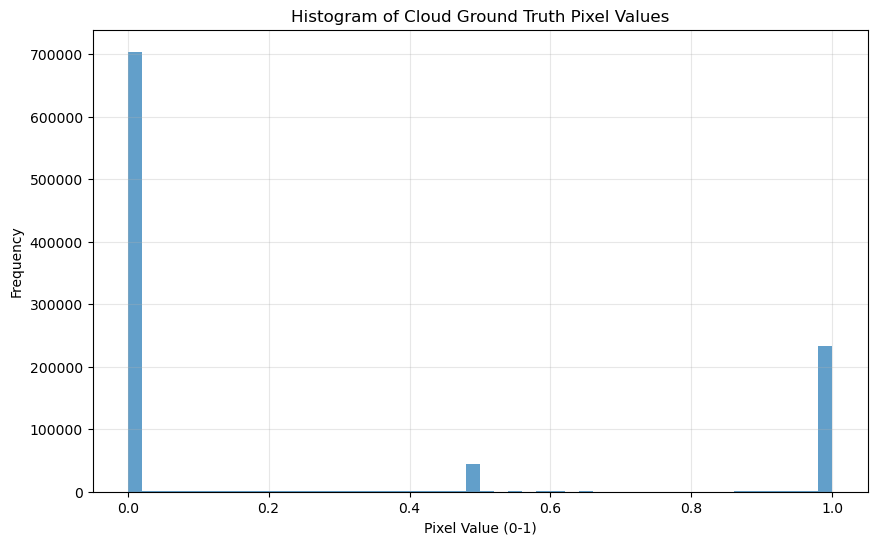

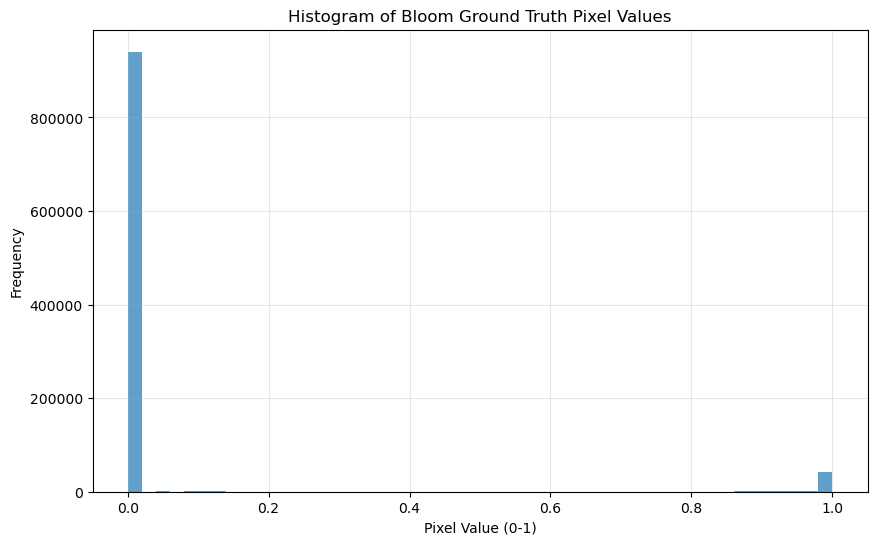

In [4]:
# Set paths
cloud_gt_folder = os.path.join(SKY_FINDER_COVER_PATH, "train/ground_truths/cloud")
bloom_gt_folder = os.path.join(SKY_FINDER_COVER_PATH, "train/ground_truths/bloom")

# Calculate weights for cloud ground truths
cloud_avg, cloud_weight = calculate_weights(cloud_gt_folder, "Cloud")

# Calculate weights for bloom ground truths
bloom_avg, bloom_weight = calculate_weights(bloom_gt_folder, "Bloom")

# Print final recommended weights
print("\n" + "="*50)
print("RECOMMENDED BCE WEIGHTS FOR LOSS FUNCTION:")
print(f"Cloud BCE weight: {cloud_weight:.4f}")
print(f"Bloom BCE weight: {bloom_weight:.4f}")
print("="*50)

# Show how to use these weights in your loss function
print("\nUse these weights in your loss function like this:")
print("```python")
print("# Define weights for BCE loss")
print(f"cloud_bce_weight = {cloud_weight:.4f}")
print(f"bloom_bce_weight = {bloom_weight:.4f}")
print("")
print("# In your loss function calculation")
print("cloud_pos_weight = torch.tensor([cloud_bce_weight], device=device)")
print("bloom_pos_weight = torch.tensor([bloom_bce_weight], device=device)")
print("")
print("# Cloud loss")
print("cloud_bce_loss = F.binary_cross_entropy_with_logits(")
print("    cloud_pred, cloud_target, pos_weight=cloud_pos_weight)")
print("cloud_dice_loss = dice_loss(cloud_pred, cloud_target)")
print("cloud_loss = cloud_dice_loss + cloud_bce_loss")
print("")
print("# Bloom loss")
print("bloom_bce_loss = F.binary_cross_entropy_with_logits(")
print("    bloom_pred, bloom_target, pos_weight=bloom_pos_weight)")
print("bloom_dice_loss = dice_loss(bloom_pred, bloom_target)")
print("bloom_loss = bloom_dice_loss + bloom_bce_loss")
print("```")